In [1]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as  np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import vgg16
from tensorflow.keras import models, Model
from annoy import AnnoyIndex
import pandas as pd
from scipy import spatial
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from pathlib import Path
import random



In [2]:

LABELS_PATH = Path("datasets_train/train_annotation/_annotation.csv")
CO2_PATH = Path("car_models_footprint.csv")

assert LABELS_PATH.is_file()
assert CO2_PATH.is_file()
assert TRAIN_DATA.is_dir()


In [5]:
class Images_Pipeline():
    def __init__(self,data_folder,IMG_SIZE = (224, 224)):
        self.img_size = IMG_SIZE
        imgs, names = self.get_all_images(data_folder)
        np.savez('all_images', imgs=imgs,names=names)

    def load_images_from_folder(self,folder):
        images = {
            'img':[],
            'name':[]
        }
        for filename in os.listdir(folder):
            file = os.path.join(folder,filename)
            if os.path.isfile(file):
                img = load_img(file,  target_size=IMG_SIZE)
                img = img_to_array(img)
                img = img.reshape((1,) + img.shape)
                if img is not None:
                    images['img'].append(img)
                    images['name'].append(filename)

        return images

    def get_all_images(self,data_folder):
        images = {
            'img':[],
            'name':[]
        }
        for folder in tqdm(os.listdir(data_folder)):
            res = self.load_images_from_folder(data_folder+'/'+folder)
            images['img'] += res['img']
            images['name'] += res['name']

        # images2 = load_images_from_folder('images_test/1/')
        imgs = np.array([images['img']])
        names = np.array([images['name']])
        return imgs, names

In [139]:
Images_Pipeline("datasets_train/car_models")

100%|██████████| 100/100 [00:03<00:00, 30.26it/s]


In [10]:
class Similarity_Model():
    def __init__(self,base_model,images_numpy_file,IMG_SIZE = (224, 224)):
        
        self.size_embedding = base_model.layers[-2].output.shape[1]
        self.model = Model(base_model.input, base_model.layers[-2].output)
        self.all_imgs, self.all_names = self.load_images_from_numpyfile(images_numpy_file)
        self.df_labels = pd.read_csv(LABELS_PATH, index_col=0)
        self.df_co2 = pd.read_csv(CO2_PATH, sep=";")
        random.seed(123)

    def generate_embeddings(self, filepath):
        self.embeddings = self.get_embeddings(self.all_imgs)
        np.save(filepath, self.embeddings)

    def load_embeddings(self, filepath):
        self.embeddings = np.load(filepath)

    def get_embeddings(self,all_imgs_arr):
        embeddings = np.zeros((len(all_imgs_arr),self.size_embedding))
        for j in tqdm(range(all_imgs_arr.shape[0])):
            img_arr = all_imgs_arr[j].reshape(1, IMG_SIZE[0], IMG_SIZE[1], 3)
            embeddings[j] = self.model.predict(all_imgs_arr[j])
            
        return embeddings

    def load_images_from_numpyfile(self,filepath):
        data = np.load(filepath)
        img = data['imgs']
        names = data['names']
        return img[0], names[0]

    def load_image(self,filepath):
        img = load_img(filepath,target_size=IMG_SIZE)
        img = img_to_array(img)
        img = img.reshape((1,) + img.shape)
        return img

    def get_nearest_neighbor_and_similarity(self,new_img_path, K):
        
        img_arr = self.load_image(new_img_path)
        img_arr = img_arr.reshape(1,1, IMG_SIZE[0], IMG_SIZE[1], 3)
        new_img_embeddings = self.model.predict(img_arr[0])
        embeddings = np.append(self.embeddings, new_img_embeddings, axis=0)
        images = np.append(self.all_imgs, img_arr, axis=0)
        name_image = np.array([Path(new_img_path).name])
        names = np.append(self.all_names, name_image, axis=0)

        dims = self.size_embedding
        n_nearest_neighbors = K+1
        trees = 10000
        file_index_to_file_vector = {}

        # build an index
        t = AnnoyIndex(dims, metric='angular')
        for i in range(embeddings.shape[0]):

            file_vector = embeddings[i]
            file_index_to_file_vector[i] = file_vector
            t.add_item(i, file_vector)
        t.build(trees)

        for i in range(embeddings.shape[0]):
            master_vector = file_index_to_file_vector[i]

            named_nearest_neighbors = []
            similarities = []
            nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)
        for j in nearest_neighbors:
            #print (j)
            neighbor_vector = embeddings[j]
            similarity = 1 - spatial.distance.cosine(master_vector, neighbor_vector)
            rounded_similarity = int((similarity * 10000)) / 10000.0
            similarities.append(rounded_similarity)
            
        if nearest_neighbors[0]==self.all_imgs.shape[0]:
            nearest_neighbors.pop(0)
            similarities.pop(0)
        
        nearest_neighbors_names = [names[i] for i in nearest_neighbors]

        # remove duplicate
        index_to_remove = []
        for i,name in enumerate(nearest_neighbors_names):
            if name==name_image[0]:
                index_to_remove.append(i)
        
        nearest_neighbors = [i for j, i in enumerate(nearest_neighbors) if j not in index_to_remove]
        similarities = [i for j, i in enumerate(similarities) if j not in index_to_remove]
        nearest_neighbors_names = [i for j, i in enumerate(nearest_neighbors_names) if j not in index_to_remove]

        return similarities, nearest_neighbors, nearest_neighbors_names

    def show_img(self,pathfile):
        array = self.load_image(pathfile)[0]
        arr = array.reshape(IMG_SIZE[0], IMG_SIZE[1],3)
        numpy_image = img_to_array(arr)
        plt.imshow(np.uint8(numpy_image))
        plt.show()
    

    def show_similar_img(self,new_img_path, K):
        self.show_img(new_img_path)
        similarities, images, names = self.get_nearest_neighbor_and_similarity(new_img_path, K+1)
        fig, axes = plt.subplots(nrows = 1, ncols = K, figsize=(12,24))
        for i in range(K):
            arr = self.all_imgs[images[i]].reshape(IMG_SIZE[0], IMG_SIZE[1],3)
            numpy_image = img_to_array(arr)
            axes[i].imshow(np.uint8(numpy_image)) 
        plt.show()

    def img_to_co2(self, img_name):
        car_model = self.df_labels[self.df_labels["im_name"]==img_name]["models"].values[0]
        if car_model==' ':
            print(f"{img_name} car model not found")
            return 0
        co2 = self.df_co2[self.df_co2['models']==car_model]["Average of CO2 (g per km)"].values[0]
        return co2

    def get_score(self,img_true, img_preds, K=1):
        co2_true = self.img_to_co2(img_true)
        co2_preds = []
        for i in range(K):
            co2_preds.append(self.img_to_co2(img_preds[i]))
        co2_pred = np.array(co2_preds).mean()
        return abs(co2_true-co2_pred)/co2_true


    def evaluate(self, test_path, limit=30, img_format="jpg", K=1):
        all_test_imgs = list(Path(test_path).glob('*/*.'+img_format))
        limit = min(limit,len(all_test_imgs))
        test_imgs = random.choices(all_test_imgs, k=limit)
        scores = []
        for img_path in tqdm(test_imgs):
            similarities, images, names = self.get_nearest_neighbor_and_similarity(img_path, K+2)
            img_name = Path(img_path).name
            score = self.get_score(img_name, names, K)
            if not score is None:
                scores.append(score)
            else:
                print(f"Score is None get_score({img_name},{names[0]})")

        scores = np.array(scores)
        return np.array(scores).mean(), scores


In [255]:
mobile_net = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=True)
sm_mobile_net = Similarity_Model(mobile_net,"all_images.npz")
sm_mobile_net.load_embeddings("emb_mobile-net-v2.npy")  
# sm_mobile_net.show_similar_img("datasets_train/train/1002373120.jpg",5)
sm_mobile_net_score = sm_mobile_net.evaluate("datasets_train/train")
print(sm_mobile_net_score)

100%|██████████| 30/30 [16:34<00:00, 33.15s/it]

0.5566291480441208


In [339]:
vgg = VGG16(include_top=True)
sm_vgg = Similarity_Model(vgg,"all_images.npz")
sm_vgg.load_embeddings("emb_vgg.npy")  
sm_vgg_score, sm_vgg_scores = sm_vgg.evaluate("datasets_train/car_models")
sm_vgg_score, sm_vgg_scores

100%|██████████| 30/30 [05:43<00:00, 11.45s/it]


(0.27439737663254865,
 array([0.        , 0.41954023, 0.45361719, 0.24205472, 2.34644951,
        0.        , 0.        , 0.16848927, 0.66708588, 0.        ,
        0.15702583, 0.        , 0.25289855, 0.30769231, 0.        ,
        0.22149281, 0.15524562, 0.        , 0.        , 0.        ,
        1.08129748, 0.        , 0.        , 0.20034247, 0.51141553,
        0.10455805, 0.19674302, 0.23669202, 0.15741489, 0.35186596]))

In [7]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True)
sm_res = Similarity_Model(resnet50,"all_images.npz")
sm_res.load_embeddings("emb_resnet-50.npy")
sm_res_score, sm_res_scores = sm_res.evaluate("datasets_train/car_models")
sm_res_score, sm_res_scores

100%|██████████| 30/30 [03:32<00:00,  7.09s/it]


(0.23103840604835896,
 array([4.43930187e-01, 4.82427418e-02, 2.13873361e-01, 2.01453092e-01,
        1.00762530e+00, 3.82775304e-01, 1.83810298e-01, 1.78229548e-01,
        3.34300060e-01, 1.65629492e-01, 1.78311334e-01, 1.23047313e-01,
        1.66932737e-01, 4.50986902e-02, 1.10683181e-01, 1.27298851e-01,
        2.53727724e-01, 1.61374072e-01, 7.04598249e-02, 1.33483463e-01,
        1.89558373e-01, 9.76484954e-04, 1.09045957e-01, 1.55843425e-01,
        4.98695369e-02, 3.39622515e-01, 2.24105212e-01, 5.30350111e-01,
        2.62414329e-01, 5.39079661e-01]))

In [11]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True)
sm_res = Similarity_Model(resnet50,"all_images.npz")
sm_res.load_embeddings("emb_resnet-50.npy")
sm_res_score, sm_res_scores = sm_res.evaluate("datasets_train/car_models",K=10)
sm_res_score, sm_res_scores

100%|██████████| 30/30 [04:18<00:00,  8.61s/it]


(0.24120106432855967,
 array([0.36543355, 0.01792958, 0.20971365, 0.09272049, 0.66694705,
        0.45822357, 0.46508261, 0.10552736, 0.57606165, 0.12022922,
        0.09623788, 0.11508286, 0.15190145, 0.17326758, 0.13984409,
        0.15756632, 0.22974191, 0.25661921, 0.04344871, 0.20934696,
        0.3399145 , 0.12424065, 0.10595965, 0.17672308, 0.16156196,
        0.39401243, 0.13709041, 0.45179125, 0.14784859, 0.54596371]))

In [14]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True)
sm_res = Similarity_Model(resnet50,"all_images.npz")
sm_res.load_embeddings("emb_resnet-50.npy")
sm_res_score, sm_res_scores = sm_res.evaluate("datasets_train/car_models",limit=100,K=5)
sm_res_score, sm_res_scores

100%|██████████| 100/100 [12:19<00:00,  7.40s/it]


(0.24177595490071596,
 array([0.36814861, 0.03081115, 0.16744809, 0.15232032, 1.09831809,
        0.34045689, 0.1781796 , 0.14182287, 0.33480481, 0.12868073,
        0.03901003, 0.15880614, 0.14408298, 0.12739967, 0.10996512,
        0.0651341 , 0.46145798, 0.26895679, 0.22060716, 0.10604827,
        0.09475769, 0.00162747, 0.08071526, 0.24895771, 0.04626006,
        0.34289212, 0.10525619, 0.5590491 , 0.19724498, 0.46404488,
        0.10694836, 0.21954035, 0.0137985 , 0.28083857, 0.00303884,
        0.0158602 , 0.22060716, 0.10248456, 0.76632228, 0.16189186,
        0.12760911, 0.12122882, 0.38832998, 0.41127422, 0.72721208,
        0.14442109, 0.01611436, 0.74339623, 0.1097132 , 0.38725547,
        0.46557971, 0.69784173, 0.38483568, 0.06266209, 0.03901003,
        0.14625843, 0.03472222, 0.2729841 , 0.10525619, 0.06253427,
        0.12085386, 0.0651341 , 0.20619718, 0.26554268, 0.29492988,
        0.13125829, 0.28205128, 0.01225919, 0.64916492, 0.12122882,
        0.08028574, 0.3727

In [10]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True)
sm_res = Similarity_Model(resnet50,"all_images.npz")
sm_res.load_embeddings("emb_resnet-50.npy")
sm_res_score, sm_res_scores = sm_res.evaluate("datasets_train/car_models", limit=100)
sm_res_score, sm_res_scores

100%|██████████| 100/100 [11:05<00:00,  6.66s/it]


(0.26734620735536674,
 array([0.60501105, 0.07271254, 0.27511634, 0.39257178, 0.25460207,
        0.35445836, 0.        , 0.        , 0.66708588, 0.        ,
        0.00701154, 0.        , 0.        , 0.5286757 , 0.16439872,
        0.09195402, 0.94326241, 0.        , 0.50479565, 0.        ,
        0.        , 0.10605619, 0.06093823, 0.        , 0.54908676,
        1.06409418, 0.22851847, 0.5468948 , 0.        , 0.35186596,
        0.25333466, 0.        , 0.        , 0.54090909, 0.00911651,
        0.        , 0.50479565, 0.        , 0.        , 0.33986495,
        0.        , 0.20255971, 1.05802817, 0.44946308, 1.53862823,
        0.21633803, 0.06539285, 0.        , 0.        , 0.        ,
        0.26475664, 0.01438849, 0.21633803, 0.31578947, 0.00701154,
        0.25521414, 0.01041667, 0.48188897, 0.22851847, 0.14724458,
        0.28472906, 0.09195402, 0.        , 0.37653671, 0.3385063 ,
        0.25148152, 0.31775701, 0.03677758, 0.76704913, 0.20255971,
        0.        , 0.2748

In [333]:
sm_vgg.evaluate("datasets_train/car_models",limit=3)

100%|██████████| 3/3 [00:36<00:00, 12.22s/it]


(0.0958867993059665, array([0.45252721, 0.        , 0.0958868 ]))

In [334]:
sm_res.evaluate("datasets_train/car_models",limit=3)

100%|██████████| 3/3 [00:21<00:00,  7.20s/it]


(0.0, array([0.54090909, 0.00911651, 0.        ]))

In [337]:
np.array([0.54090909, 0.00911651, 0.]).mean()

0.18334186666666666

In [343]:
resnet50_v2 = tf.keras.applications.resnet_v2.ResNet50V2(include_top=True)
sm_res_v2 = Similarity_Model(resnet50_v2,"all_images.npz")
sm_res_v2.load_embeddings("emb_resnet-50-v2.npy")
sm_res_v2_score, sm_res_v2_scores = sm_res_v2.evaluate("datasets_train/car_models")
sm_res_v2_score, sm_res_v2_scores

100%|██████████| 30/30 [03:27<00:00,  6.91s/it]


(0.4043270711600654,
 array([0.60501105, 0.09195402, 0.20729537, 0.31725347, 0.24722626,
        0.59752848, 0.2303612 , 0.15375357, 0.35698886, 0.40526316,
        0.76821436, 0.28387601, 0.39186795, 0.3649635 , 0.15945717,
        0.55172414, 0.4306198 , 0.12650454, 0.        , 0.40614334,
        0.23502248, 0.90186421, 0.10121074, 0.53240253, 0.09316432,
        1.02158273, 0.33986495, 0.60614702, 0.29066568, 1.31188119]))

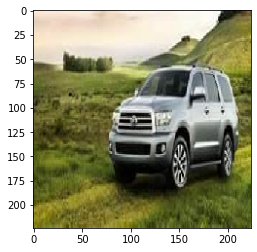

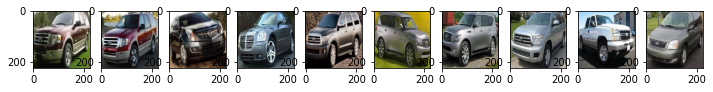

In [202]:
sm_res.show_similar_img("datasets_train/train/1002373120.jpg",10)

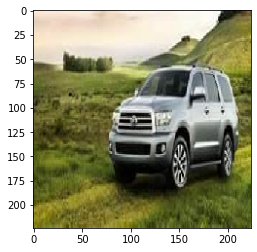

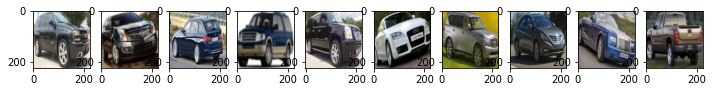

In [203]:
sm_vgg.show_similar_img("datasets_train/train/1002373120.jpg",10)

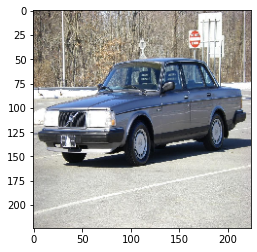

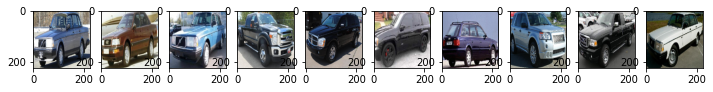

In [191]:
sm_res.show_similar_img("datasets_train/train/1044709376.jpg",10)

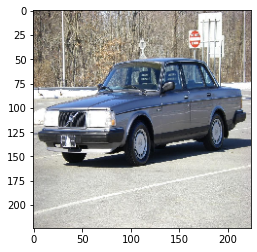

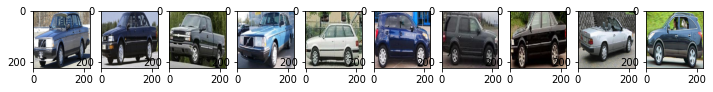

In [192]:
sm_vgg.show_similar_img("datasets_train/train/1044709376.jpg",10)